[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


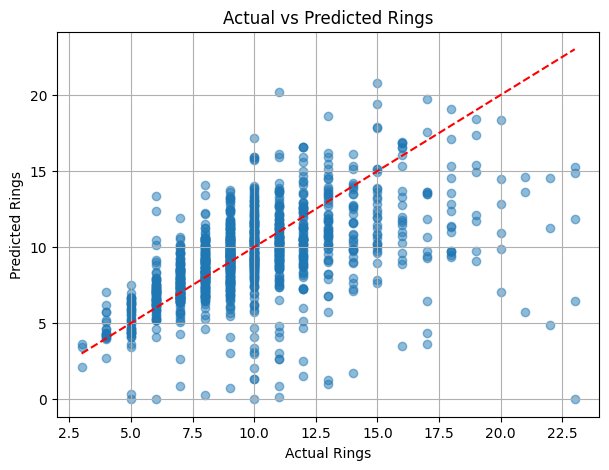

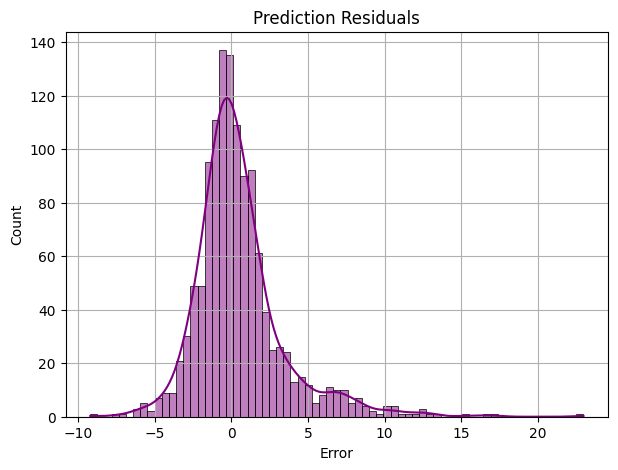

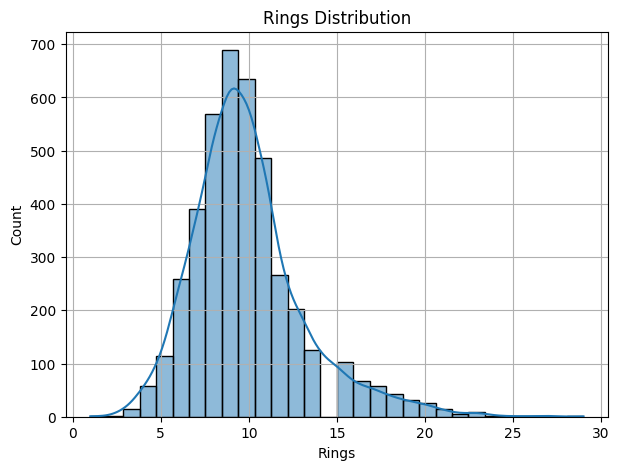

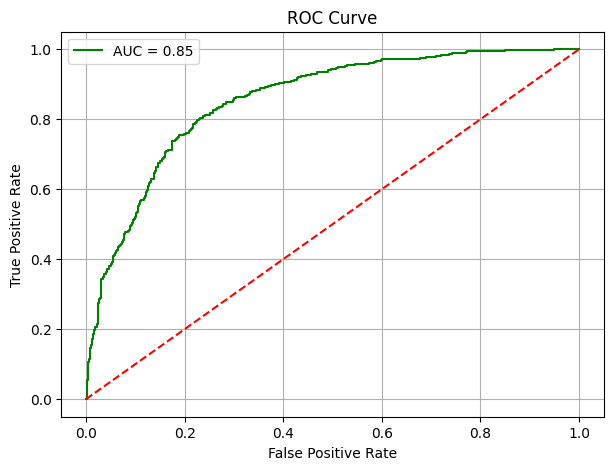

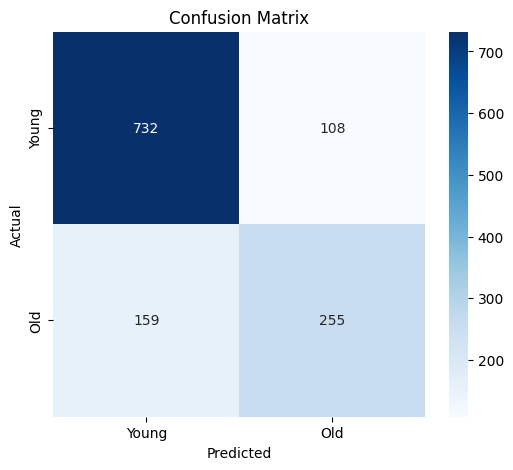

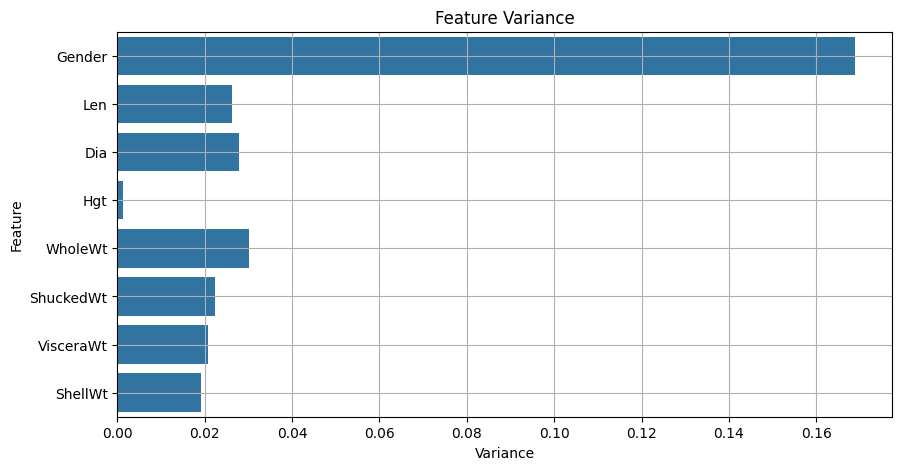


Topic 1:
year, also, technology, computer, new, music, one, said, people, game

Topic 2:
also, one, award, win, first, game, best, year, film, said

Topic 3:
sale, market, mr, would, share, year, firm, company, bn, said

Topic 4:
could, country, new, people, also, government, would, mr, year, said

Topic 5:
new, also, election, party, labour, service, people, would, mr, said

Regression RMSE: 2.99
Regression R2 Score: 0.12
Classification Accuracy: 0.79
Classification ROC AUC: 0.85


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download nltk resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

# load abalone and bbc datasets
abalone_data = pd.read_csv("https://raw.githubusercontent.com/UdayPrasadB/MOUnderUncertainityUday/refs/heads/main/abalone.data", header=None)
bbc_data = pd.read_csv("https://raw.githubusercontent.com/UdayPrasadB/MOUnderUncertainityUday/refs/heads/main/BBCNews.csv")

# rename abalone columns
abalone_data.columns = ['Gender', 'Len', 'Dia', 'Hgt', 'WholeWt', 'ShuckedWt', 'VisceraWt', 'ShellWt', 'Rings']
abalone_data['Gender'] = LabelEncoder().fit_transform(abalone_data['Gender'])

# prepare features and targets
features = abalone_data.drop(columns='Rings')
target_reg = abalone_data['Rings']
target_cls = (target_reg > 10).astype(int)

# normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# split for regression
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(features_scaled, target_reg, test_size=0.3, random_state=42)

# split for classification
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(features_scaled, target_cls, test_size=0.3, random_state=42)

# train regression model
reg_model = GaussianProcessRegressor(kernel=RBF(), alpha=0.1)
reg_model.fit(x_train_r, y_train_r)
pred_r = reg_model.predict(x_test_r)

# calculate regression metrics
rmse_val = np.sqrt(mean_squared_error(y_test_r, pred_r))
r2_val = r2_score(y_test_r, pred_r)

# train classification model
cls_model = GaussianProcessClassifier(kernel=RBF(), max_iter_predict=100)
cls_model.fit(x_train_c, y_train_c)
pred_c = cls_model.predict(x_test_c)
prob_c = cls_model.predict_proba(x_test_c)[:, 1]

# calculate classification metrics
acc_val = accuracy_score(y_test_c, pred_c)
auc_val = roc_auc_score(y_test_c, prob_c)
conf_mat = confusion_matrix(y_test_c, pred_c)

# plot actual vs predicted
plt.figure(figsize=(7, 5))
plt.scatter(y_test_r, pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.title("Actual vs Predicted Rings")
plt.xlabel("Actual Rings")
plt.ylabel("Predicted Rings")
plt.grid()
plt.show()

# plot residuals
residual = y_test_r - pred_r
plt.figure(figsize=(7, 5))
sns.histplot(residual, kde=True, color="purple")
plt.title("Prediction Residuals")
plt.xlabel("Error")
plt.grid()
plt.show()

# plot distribution of rings
plt.figure(figsize=(7, 5))
sns.histplot(target_reg, bins=30, kde=True)
plt.title("Rings Distribution")
plt.xlabel("Rings")
plt.grid()
plt.show()

# plot ROC curve
fpr_val, tpr_val, _ = roc_curve(y_test_c, prob_c)
plt.figure(figsize=(7, 5))
plt.plot(fpr_val, tpr_val, label=f"AUC = {round(auc_val, 2)}", color="green")
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
plt.show()

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Young", "Old"], yticklabels=["Young", "Old"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# plot feature variance
var_vals = np.var(features_scaled, axis=0)
plt.figure(figsize=(10, 5))
sns.barplot(x=var_vals, y=features.columns)
plt.title("Feature Variance")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.grid()
plt.show()

# clean bbc text
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    tokens = word_tokenize(str(text).lower())
    clean = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(clean)

bbc_data['clean_text'] = bbc_data['descr'].apply(process_text)

# lda model
vec = CountVectorizer(max_df=0.95, min_df=2)
text_matrix = vec.fit_transform(bbc_data['clean_text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(text_matrix)

# show lda topics
def show_topics(model, vec, top_n=10):
    vocab = vec.get_feature_names_out()
    for i, topic in enumerate(model.components_):
        print(f"\nTopic {i+1}:")
        print(", ".join([vocab[j] for j in topic.argsort()[-top_n:]]))

show_topics(lda_model, vec)

# print final results
print("\nRegression RMSE:", round(rmse_val, 2))
print("Regression R2 Score:", round(r2_val, 2))
print("Classification Accuracy:", round(acc_val, 2))
print("Classification ROC AUC:", round(auc_val, 2))

